In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Transform the data (normalization and data augmentation)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 100702509.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [ ]:
# Define the classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
batchsize = 16

In [ ]:
from torch.utils.data import DataLoader
data_loader = DataLoader(trainset, batch_size = batchsize, shuffle = True,  drop_last=True)

In [ ]:
for images, labels in data_loader:
    break
print(images.shape)

torch.Size([16, 3, 64, 64])


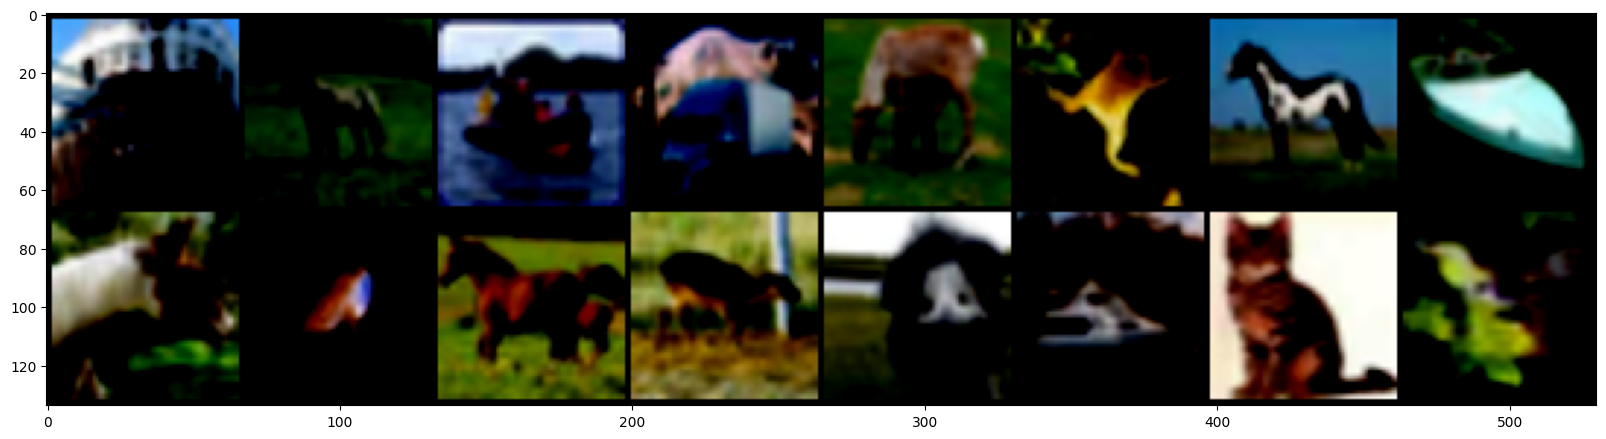

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

im = make_grid(images, nrow=8)  # 8 images in a row. the default nrow is 8

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))); # we see that dataloader has shuffle the images

## Denormalize the images before displaying

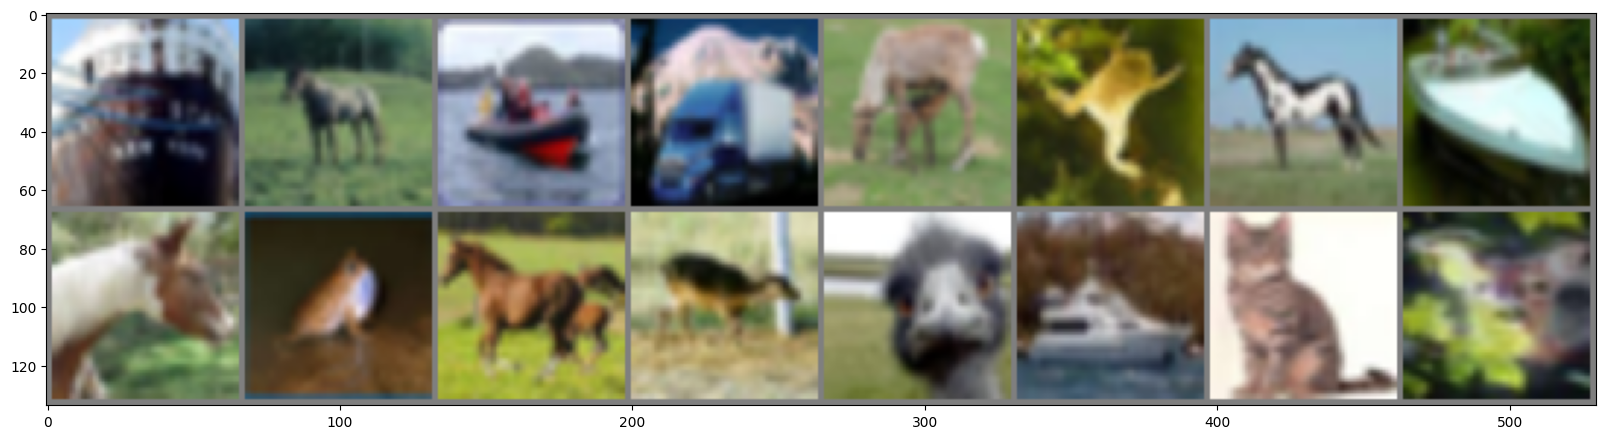

In [ ]:
im = make_grid(images, nrow=8)  # 16 images in a row
# Inverse normalize the images

inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
im_inv = inv_normalize(im)

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose((im_inv.numpy()*255).astype(np.uint8), (1, 2, 0))); # we see that dataloader has shuffle the images

## Create class for the discriminator

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)

In [ ]:
disModel = discriminator()
y = disModel(torch.randn(10,3,64,64))
y.shape

torch.Size([10, 1])

## Create discriminator class

In [ ]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 4, 2, 1, bias=False)

    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x

## See what generator is producing without training

torch.Size([10, 3, 64, 64])


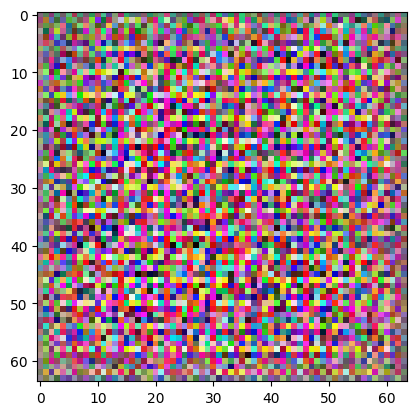

In [ ]:
genModel = generator()
out = genModel(torch.randn(10,100,1,1))
print(out.shape)
img = out[0,:,:,:].squeeze().detach().numpy().transpose((1,2,0))
img = (img-np.min(img)) / (np.max(img)-np.min(img)) # Denormalize the image
plt.imshow(img);

## Loss Function

In [ ]:
lossfunc = nn.BCELoss()

In [ ]:
disModel = disModel.to(device)
genModel = genModel.to(device)

In [ ]:
dis_optimizer = torch.optim.Adam(disModel.parameters(), lr=.0002, betas=(.5,.999))
gen_optimizer = torch.optim.Adam(genModel.parameters(), lr=.0002, betas=(.5,.999))

In [28]:
epochs = 10

losses  = []
disOutputs = []

for epoch in range(epochs):

  for images,_ in data_loader:

    real_images = images.to(device)

    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)


#  TRAINING THE DISCRIMINATOR   #

    ypred_real   = disModel(real_images)                                                                # Output of the disModel
    dis_loss_real = lossfunc(ypred_real,real_labels)                                              # Here all the labels are 1

    fake_images = genModel(torch.randn(batchsize,100,1,1).to(device))                            # Output of genModel
    ypred_fake   = disModel(fake_images)                                                         # Pass through discriminator
    dis_loss_fake = lossfunc(ypred_fake,fake_labels)                                                # Here all the labels are 0

    # Total Loss
    dis_loss = dis_loss_real + dis_loss_fake

    dis_optimizer.zero_grad()
    dis_loss.backward()
    dis_optimizer.step()



    # TRAIN GENERATOR

    fake_images = genModel( torch.randn(batchsize,100,1,1).to(device) )
    ypred_fake   = disModel(fake_images)

    gen_loss = lossfunc(ypred_fake,real_labels)

    gen_optimizer.zero_grad()
    gen_loss.backward()
    gen_optimizer.step()

    losses.append([dis_loss.item(),gen_loss.item()])

    out1 = torch.mean((ypred_real>.5).float()).detach()
    out2 = torch.mean((ypred_fake>.5).float()).detach()
    disOutputs.append([out1,out2])

   #printing the epochs
  #if (epoch % 10) == 0:
  print(f' Epochs : {epoch}/{epochs}')


 Epochs : 0/10
 Epochs : 1/10
 Epochs : 2/10
 Epochs : 3/10
 Epochs : 4/10
 Epochs : 5/10
 Epochs : 6/10
 Epochs : 7/10
 Epochs : 8/10
 Epochs : 9/10


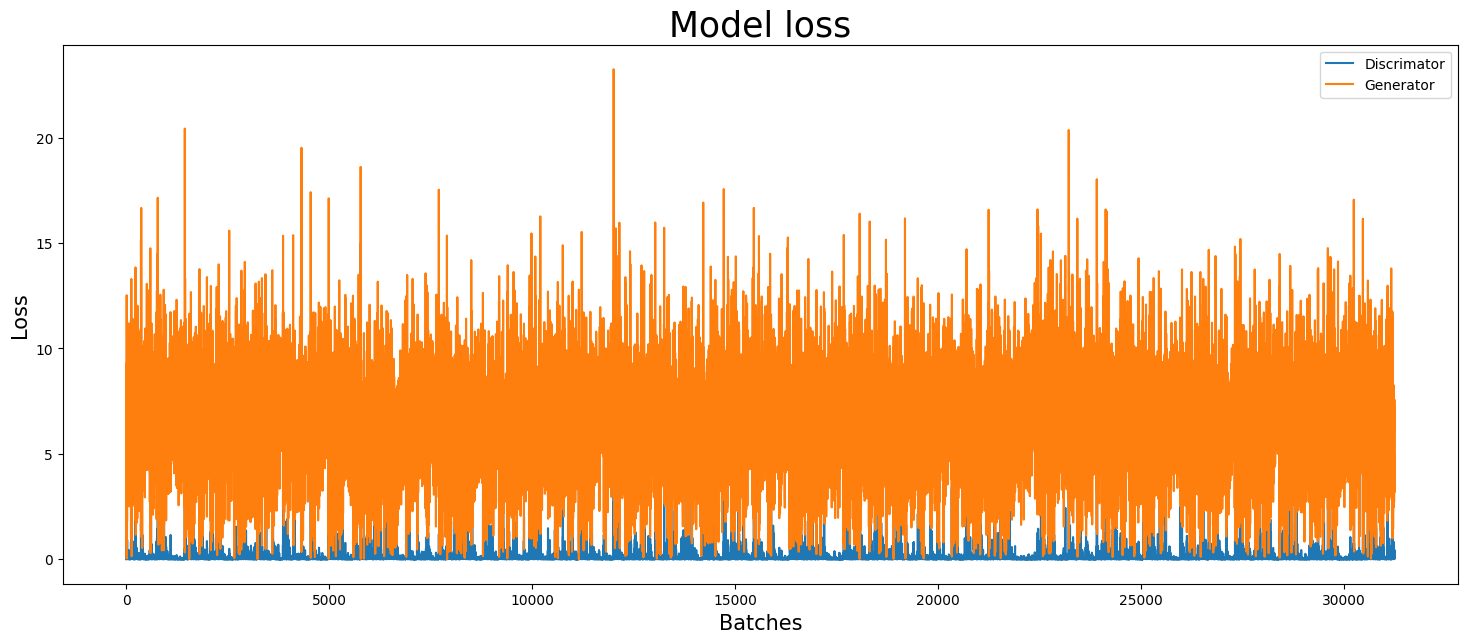

In [29]:
plt.figure(figsize=(18,7))
plt.plot(losses)
plt.xlabel('Batches', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('Model loss', fontsize = 25)
plt.legend(['Discrimator','Generator'])
# plt.xlim([4000,5000])
# plt.ylim([0,7])
plt.show()


In [30]:
disOutputs = torch.tensor(disOutputs, device = 'cpu')

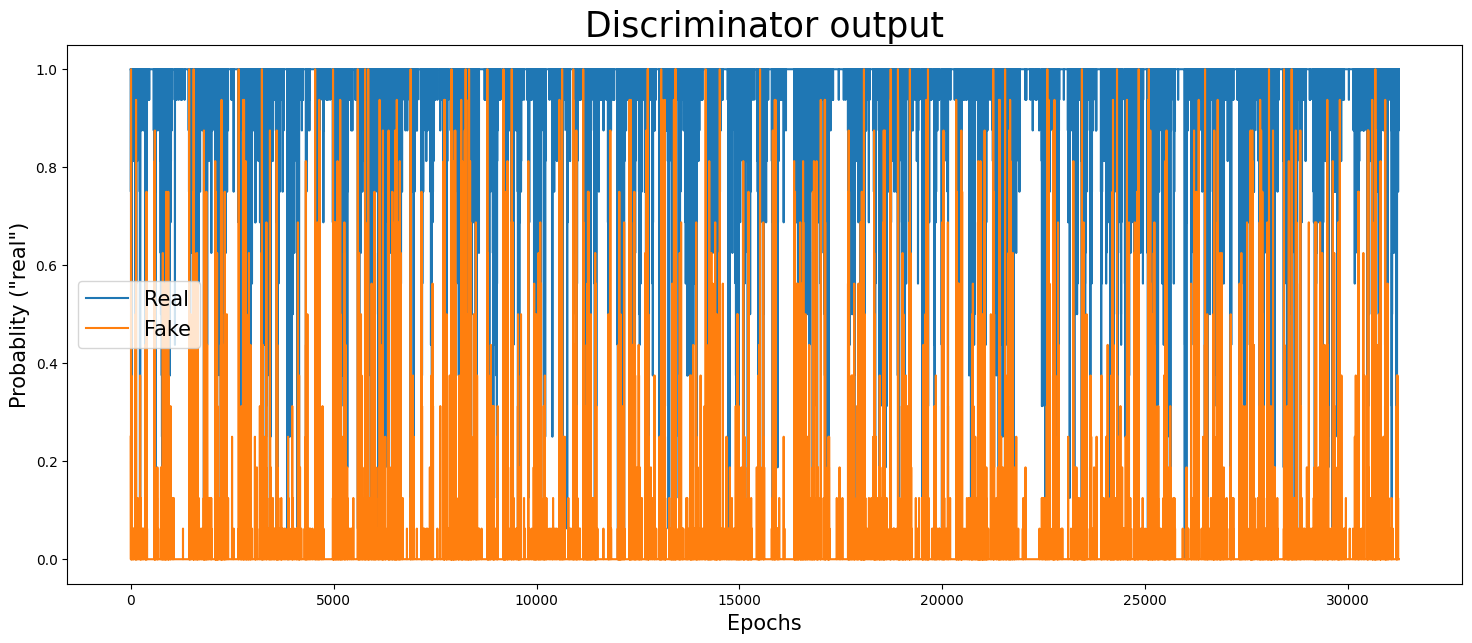

In [31]:
plt.figure(figsize=(18,7))
plt.plot(np.array(disOutputs))
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Probablity ("real")',fontsize = 15)
plt.title('Discriminator output', fontsize = 25)
plt.legend(['Real','Fake'], fontsize = 15)
plt.show()

## Test with Random Sample

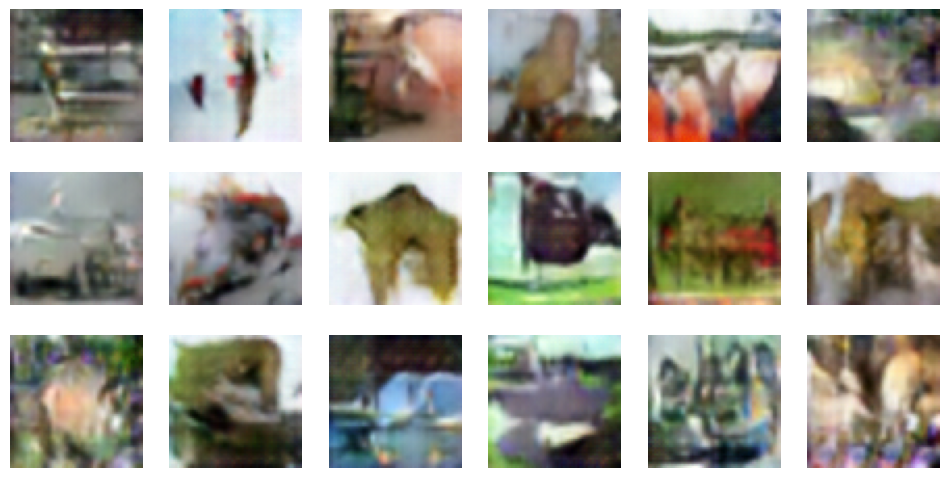

In [38]:
batch_size = 18
Noise = torch.randn(batch_size, 100, 1, 1)

genModel.eval()
fake_data = genModel(Noise.to(device))
fake_data = fake_data.cpu()

fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    if i >= batch_size:  # Break loop if we've plotted enough images
        break
    pic = fake_data[i].detach().squeeze().numpy().transpose((1, 2, 0))
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
    ax.imshow(pic)
    ax.axis('off')

plt.show()